In [48]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib as mpl

In [49]:
import numpy as np
import pandas as pd

In [50]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [51]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [52]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [53]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [54]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [55]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [56]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

,date,station,precipitation,temperature
0,2016-08-23,USC00519397,0.00,81.0
1009,2016-08-23,USC00517948,NaN,80.0
1529,2016-08-23,USC00519281,1.79,77.0
704,2016-08-23,USC00514830,0.05,80.0
361,2016-08-23,USC00513117,0.15,76.0


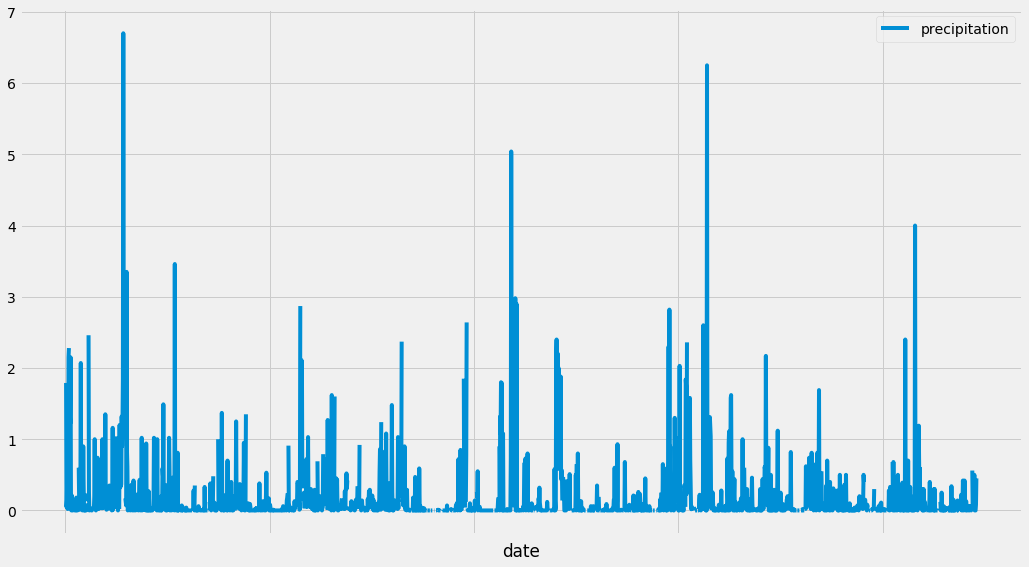

In [57]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_day = list(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
last_day_str = ''.join(last_day)
last_day_datetime = dt.datetime.strptime(last_day_str,'%Y-%m-%d')
one_year_ago = last_day_datetime -dt.timedelta(days=365)
one_year_ago_str = dt.datetime.strftime(one_year_ago,'%Y-%m-%d')
one_year_ago_str

# Perform a query to retrieve the data and precipitation scores
weather_data = session.query(Measurement).filter(Measurement.date >= one_year_ago_str).all()

#for d in weather_data:
#    print(d.id, d.station, d.date, d.prcp, d.tobs)


# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df_weather = pd.DataFrame([(d.date, d.station, d.prcp, d.tobs) for d in weather_data], columns = ["date","station","precipitation","temperature"]).sort_values(by=["date"])


# Use Pandas Plotting with Matplotlib to plot the data
mpl.rcParams['figure.figsize'] = [16,9]
df_weather.plot("date","precipitation", grid=True)
df_weather.head()

![precipitation](Images/precipitation.png)

In [58]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_weather.describe()

,precipitation,temperature
count,2021.000000,2230.000000
mean,0.177279,74.590583
std,0.461190,4.611667
min,0.000000,58.000000
25%,0.000000,72.000000
50%,0.020000,75.000000
75%,0.130000,78.000000
max,6.700000,87.000000


![describe](Images/describe.png)

In [59]:
# Design a query to show how many stations are available in this dataset?

    # with pandas
    # stations = df_weather["station"].value_counts()
    # len(stations)
    
# num_station = session.query(func.count(Station.station)).first()[0]
# print("There are {} stations.".format(num_station))

num_station = session.query(Measurement.station, func.count(Measurement.prcp)). \
            filter(Measurement.date >= one_year_ago_str). \
            group_by(Measurement.station). \
            order_by(func.count(Measurement.prcp).desc()). \
            all()
len(num_station)

7

In [61]:
# What are the most active stations? (i.e. what stations have the most rows)?

    # using pandas
    # most_active_station = stations.keys()[0]
    # most_active_station

most_active_station = session.query(Measurement.station, func.count(Measurement.prcp)). \
            filter(Measurement.date >= one_year_ago_str). \
            group_by(Measurement.station). \
            order_by(func.count(Measurement.prcp).desc()). \
            first()
most_active_station[0]

'USC00519397'

In [62]:
# List the stations and the counts in descending order.
num_station

[('USC00519397', 359),
 ('USC00519281', 352),
 ('USC00513117', 343),
 ('USC00516128', 328),
 ('USC00519523', 314),
 ('USC00514830', 265),
 ('USC00517948', 60)]

In [63]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temp_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)). \
        filter(Measurement.date >= one_year_ago_str). \
        filter(Measurement.station == most_active_station[0]).first()

print("The lowest temperature:  {}".format(temp_data[0]))
print("The highest temperature: {}".format(temp_data[1]))
print("Average temperature:     {}".format(temp_data[2]))

The lowest temperature:  60.0
The highest temperature: 87.0
Average temperature:     75.21052631578948


In [64]:
# Choose the station with the highest number of temperature observations.

most_active_station_temp = session.query(Measurement.station, func.count(Measurement.tobs)). \
            group_by(Measurement.station). \
            order_by(func.count(Measurement.tobs).desc()). \
            first()
most_active_station_temp[0]

'USC00519281'

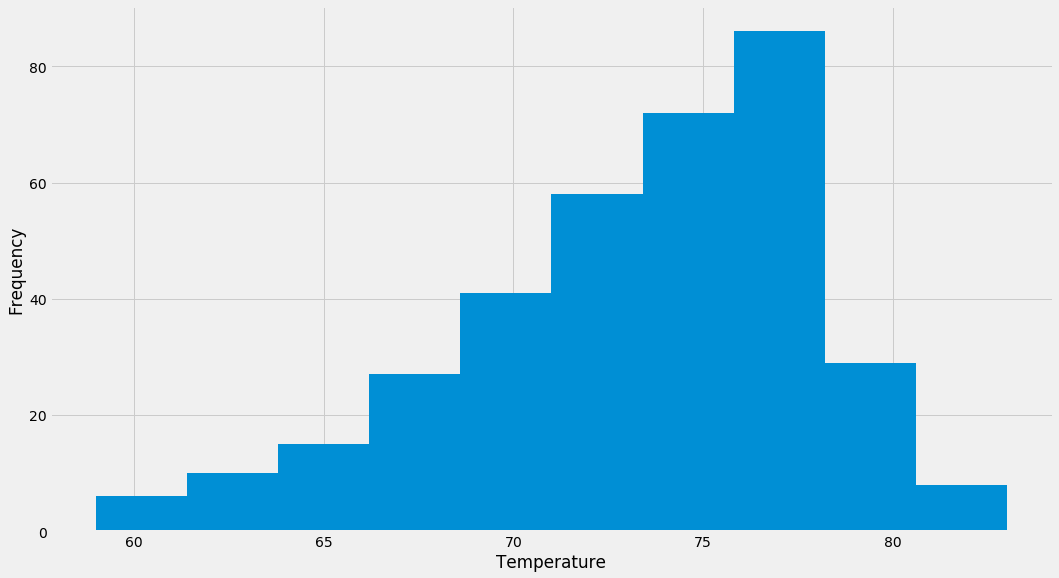

In [65]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data_from_most_active_station = session.query(Measurement.tobs). \
            filter(Measurement.date >= one_year_ago_str). \
            filter(Measurement.station == most_active_station_temp[0]). \
            all()

temp_data = [d[0] for d in temp_data_from_most_active_station]
plt.hist(temp_data)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
mpl.rcParams['figure.figsize'] = [16,9]

![precipitation](Images/station-histogram.png)

In [66]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [67]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = str(int(last_day_str[0:4])-1)+'-02-28'
end_date = str(int(last_day_str[0:4])-1)+'-03-05'
previous_temp_trip = calc_temps(start_date, end_date)
previous_temp_trip

[(62.0, 69.88636363636364, 80.0)]

([<matplotlib.axis.XTick at 0x2116c3546d8>],
 <a list of 0 Text xticklabel objects>)

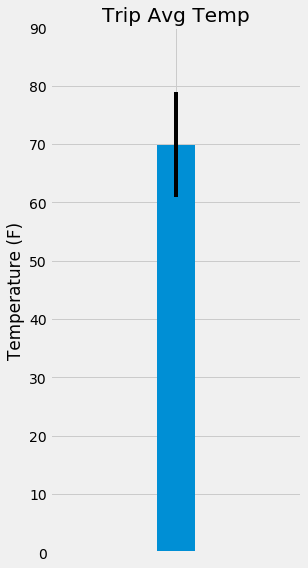

In [69]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

mpl.rcParams['figure.figsize'] = [4,9]

temp_trip_avg = previous_temp_trip[0][1]
temp_trip_err = (previous_temp_trip[0][2] - previous_temp_trip[0][0])/2

plt.bar(x= 0,  height= temp_trip_avg, width=0.3, yerr = temp_trip_err)
plt.xlim(-1,1)
plt.ylim(0,90)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.xticks([0],"")

In [70]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
precipitation_trip = session.query(Measurement.station, func.sum(Measurement.prcp)). \
            filter(Measurement.date.between(start_date, end_date)). \
            group_by(Measurement.station). \
            order_by(func.sum(Measurement.prcp).desc()). \
            all()
df_precipitation_trip = pd.DataFrame(precipitation_trip, columns = ["station", "total_rainfall"])

station_data = session.query(Station).all()
df_station_data = pd.DataFrame([(d.station, d.name, d.latitude, d.longitude, d.elevation) for d in station_data], columns = ["station", "name", "latitude", "longitude","elevation"])

df_precipitation_extend = pd.merge(df_precipitation_trip, df_station_data, on="station")
df_precipitation_extend

,station,total_rainfall,name,latitude,longitude,elevation
0,USC00519523,0.33,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
1,USC00514830,0.12,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,USC00516128,0.02,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
3,USC00519281,0.01,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
4,USC00513117,0.00,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
5,USC00519397,0.00,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,NaN,"PEARL CITY, HI US",21.39340,-157.97510,11.9
